fastai_statoil_motiur

Replicating: https://github.com/motiur/fastai/blob/master/statoil_4.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH  = "data/"; TRAIN = "train/"; VALID = "valid/"; TEST  = "test/"

In [4]:
train_data = pd.read_json(PATH+'train.json')

In [5]:
band_1 = [np.array(band).astype(np.float32).reshape(75,75) for band in train_data['band_1']]
band_2 = [np.array(band).astype(np.float32).reshape(75,75) for band in train_data['band_2']]

In [6]:
band_1 = np.array(band_1)
band_2 = np.array(band_2)

All implementations I've seen, turn the data into a 3D tensor. Think it's safe to say, if you want it any other way: you have to refactor the architecture itself.

*Okay... no shit.* Well I was having trouble getting a 3D tensor in there anyhow. Will check that soon after this notebook.

In [7]:
train_data_array = np.concatenate([band_1[:,:,:, np.newaxis], 
                                   band_2[:,:,:, np.newaxis],
                                   ((band_1+band_2)/2)[:,:,:, np.newaxis]],
                                  axis=-1)

In [8]:
band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_data["band_1"]])
band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_data["band_2"]])
train_data_array = np.concatenate([band_1[:, :, :, np.newaxis], band_2[:, :, :, np.newaxis],
                                   ((band_1+band_2)/2)[:, :, :, np.newaxis]], axis=-1)


In [9]:
%rm -r data/train/ship/*.jpg
%rm -r data/train/ice/*.jpg

In [10]:
for idx in range(len(train_data_array)):
    if train_data.iloc[idx]['is_iceberg'] == 0:
        CAT = 'ship/'
    else:
        CAT = 'ice/'
    scipy.misc.imsave(PATH+TRAIN+CAT+'{:0=4d}.jpg'.format(idx), train_data_array[idx])

# %rm -rf data/train/ship/*.jpg
# %rm -rf data/train/ice/*.jpg

Interesting message for usage of `.ix`:

```
/home/wnixalo/miniconda3/envs/FAI/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
```

I'll use `.iloc` since I'm using integer indices then.

In [9]:
# CATS = ['ice/','ship/']
# for CAT in CATS:
#     %cd $PATH$TRAIN$CAT
    
#     g = glob('*.jpg')
#     shuf = np.random.permutation(g)
#     for i in range(400): os.rename(shuf[i], PATH+VALID+CAT+shuf[i])

NOTE: `ImageClassifierData.from_paths(..)` **WILL** fail if `val_name` and `test_name` do not equal `'valid'` and `'test'`. I though I could get away w/ calling them `'train'` to proceed w/o validation or test folders. Also I *think* the `PATH` par of `.from_paths(..)` must be the *absolute* path. (ie: from home)

NOTE: *Ahhhh*... I think what it needs is for those folders to not be empty..

--> Confirmed, and *both* are true.

In [30]:
ARCH = resnet34
sz = 224

resnet_data = ImageClassifierData.from_paths(os.getcwd()+'/'+PATH, bs=16, 
                                             tfms=tfms_from_model(ARCH, sz, 
                                                                  aug_tfms=transforms_basic, 
                                                                  max_zoom=1.0),
                                             trn_name='train', val_name='valid',
                                             test_name='test', num_workers=8)

# resnet_data = ImageClassifierData.from_paths(os.getcwd()+'/'+PATH, bs = 16,
#                                       tfms=tfms_from_model(ARCH, sz,
#                                                            aug_tfms=transforms_basic,
#                                                            max_zoom = 1.0), 
#                                       trn_name='train',val_name='valid', 
#                                       test_name = 'test',num_workers=8)

learn = ConvLearner.pretrained(ARCH, resnet_data, precompute=True)

100%|██████████| 527/527 [01:28<00:00,  5.94it/s]


In [31]:
learn.fit(1e-3, 3)

[ 0.       0.54137  0.41833  0.79394]                       
[ 1.       0.50318  0.36625  0.82549]                       
[ 2.       0.47231  0.35622  0.84096]                       



Okay, a collossal memory issue here. Calling `X = pd.read_json(json_file_path)` will load that into memory, but will NOT free memory previously allocated in X... So you can crash your system in a few `shift-return`'s... 

Unfortunately running `del X` will only free the memory currently allocated to `X`. What was bound before will still be occupied in RAM. ffs...

**NOTE:** the below `test_...` operations should be above with their `train_...` counterparts.

In [11]:
test_data = pd.read_json(PATH+"test.json")

In [12]:
test_band_1 = [np.array(band).astype(np.float32).reshape(75,75) for band in test_data['band_1']]
test_band_2 = [np.array(band).astype(np.float32).reshape(75,75) for band in test_data['band_2']]
test_band_1 = np.array(test_band_1)
test_band_2 = np.array(test_band_2)
test_data_array = np.concatenate([test_band_1[:,:,:, np.newaxis], 
                                  test_band_2[:,:,:, np.newaxis],
                                  ((test_band_1+test_band_2)/2)[:,:,:, np.newaxis]],
                                  axis=-1)

In [13]:
test_data.shape

(8424, 4)

In [14]:
test_data_array.shape

(8424, 75, 75, 3)

In [32]:
# save testing data to test folder:
for idx in range(len(test_data_array)):
    scipy.misc.imsave(PATH+TEST+'{:0=4d}.jpg'.format(idx), test_data_array[idx])

In [33]:
test_preds = learn.predict(is_test=True)
print(test_preds.shape)

(8424, 2)


In [34]:
λrf = learn.lr_find()

 79%|███████▉  | 80/101 [00:00<00:03,  6.89it/s, loss=1.37] 


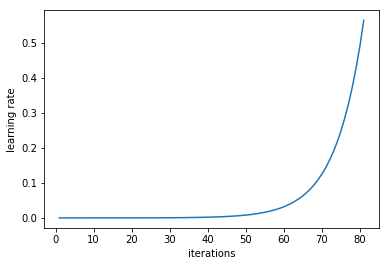

In [35]:
learn.sched.plot_lr()

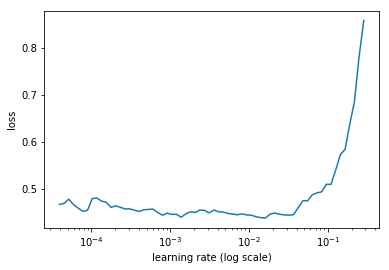

In [36]:
learn.sched.plot()

#### Differential Learning & Finetuning

In [37]:
learn.precompute = False
learn.fit(1e-2, 1, cycle_len=1)

[ 0.       0.51223  0.34626  0.82178]                        



In [39]:
# Validation accuracy and log loss (although I didn't separate any validation data here)
from sklearn import metrics
log_preds, labels = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, labels), metrics.log_loss(labels, probs)

(0.82730673316708225, 0.35399877791289563)

In [40]:
learn.unfreeze()
λr = np.array([1e-2, 3e-2, 9e-2])

In [41]:
learn.fit(λr, 3, cycle_len=1, cycle_mult=3)

[ 0.       1.81896  1.52258  0.61819]                       
[ 1.       2.05542  1.2733   0.57611]                       
[ 2.       1.04116  0.67779  0.56745]                       
[ 3.       0.73303  0.65036  0.56807]                        
[ 4.       0.77082  0.74725  0.53465]                        
[ 5.       0.73078  0.67012  0.55012]                        
[ 6.       0.65693  0.69824  0.66399]                        
[ 7.       0.61545  0.54296  0.71163]                        
[ 8.       0.59277  0.46422  0.78775]                        
[ 9.       0.53985  0.44084  0.80198]                        
[ 10.        0.51571   0.44041   0.79517]                    
[ 11.        0.48845   0.4046    0.8224 ]                    
[ 12.        0.47839   0.40626   0.81993]                    



In [44]:
# file submission
test_preds = learn.TTA(is_test=True)
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['is_iceberg'] = pd.DataFrame({'is_iceberg':list(np.exp(test_preds[0][:][:,0]))})
submission.to_csv(PATH+'results/'+'submission_fastai_motiurrepl.csv', index = False)